# O3 and Weather data gathering (All BE stations - BE: 79)

### Plain txt file to dataframe

Background-rural both for Ozone (O3 - Max daily 8-hour mean *max8h* ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-8) for the stations in Belgium: "BExxxxx0001xxx"

In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import timedelta
from numpy import genfromtxt

dirpath = "AirBase_BE_v8/OzoneBelgium"
fnames = listdir(dirpath)  # Read all files in directory
stationLabels = ['O3_'] * len(fnames)  # Suffix for Ozone label
for i in range(len(fnames)):
    stationLabels[i] += fnames[i][:7]  # Add the first area code name


In [2]:
# Read last data, 2013-2019
ts_last = pd.read_pickle("../../EAAAData/BE_AQeReporting_2013-2018/Ozone/ts_day8hmax.pkl")

# No timezoneinfo
ts_last = ts_last.tz_convert(None)

# Normalized datetime index, removing the hour
ts_last.index = ts_last.index.normalize()

for column in ts_last.columns:
    if column != "O3":
        if column not in stationLabels:
            stationLabels.append(column)

# TODO: add -1 lag
# previous_columns = ts_last.columns
# for column in previous_columns:
#     print("column", column)
#     ts_last[column + "-1"] = ts_last[column].shift()

ts_last.tail()

,O3,O3_BETB006,O3_BETR221,O3_BETN100,O3_BETR222,O3_BETN035,O3_BETR801,O3_BETR811,O3_BETN040,O3_BETN093,...,O3_BETN043,O3_BETR740,O3_BETN046,O3_BETWOL1,O3_BETN016,O3_BETN073,O3_BETB011,O3_BETR841,O3_BETN027,O3_BETN060
2019-01-21,NaN,NaN,23.0000,48.812500,38.375000,32.250000,12.687500,21.312500,32.937500,43.750000,...,17.4375,26.937500,29.437500,22.4375,24.125000,45.437500,24.857143,NaN,32.000000,25.625000
2019-01-22,NaN,NaN,22.7500,51.714286,32.750000,34.285714,18.312500,31.357143,40.785714,39.285714,...,24.5000,37.142857,22.785714,32.3750,27.357143,44.750000,32.750000,NaN,20.000000,33.250000
2019-01-23,NaN,NaN,28.8125,37.312500,35.312500,22.416667,21.714286,25.937500,27.375000,41.785714,...,21.7500,24.937500,33.437500,15.8125,31.375000,40.250000,19.687500,NaN,32.562500,12.125000
2019-01-24,NaN,NaN,39.1875,40.312500,45.571429,17.312500,5.562500,9.750000,23.500000,50.571429,...,8.6875,8.750000,38.687500,14.5625,19.375000,43.000000,17.312500,NaN,36.437500,9.142857
2019-01-25,NaN,NaN,27.1000,52.428571,44.571429,43.833333,26.000000,34.300000,47.357143,41.916667,...,23.0000,41.300000,41.583333,28.4000,32.250000,50.857143,40.800000,NaN,36.416667,37.600000


In [3]:
columnLabels = ['PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4',  # Attach all the ECMWF weather labels
                 'SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH',
                 'TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T',
                 'RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR']
columnLabels = stationLabels + columnLabels  # Join lists
for i in range(len(fnames)):
    columnLabels.append(stationLabels[i] + "-1")  # Append the lag-1 day values

In [4]:
ts_last["O3_BETR740"].tail()

2019-01-21    26.937500
2019-01-22    37.142857
2019-01-23    24.937500
2019-01-24     8.750000
2019-01-25    41.300000
Freq: D, Name: O3_BETR740, dtype: float64

In [5]:
list(ts_last.columns)

['O3',
 'O3_BETB006',
 'O3_BETR221',
 'O3_BETN100',
 'O3_BETR222',
 'O3_BETN035',
 'O3_BETR801',
 'O3_BETR811',
 'O3_BETN040',
 'O3_BETN093',
 'O3_BETR831',
 'O3_BETN063',
 'O3_BETR710',
 'O3_BETR001',
 'O3_BETN066',
 'O3_BETN029',
 'O3_BETN054',
 'O3_BETN113',
 'O3_BETR502',
 'O3_BETN132',
 'O3_BETN121',
 'O3_BETR240',
 'O3_BETN045',
 'O3_BETR701',
 'O3_BETM705',
 'O3_BETR012',
 'O3_BETN012',
 'O3_BETN051',
 'O3_BETB004',
 'O3_BETN085',
 'O3_BETN052',
 'O3_BETN070',
 'O3_BETN043',
 'O3_BETR740',
 'O3_BETN046',
 'O3_BETWOL1',
 'O3_BETN016',
 'O3_BETN073',
 'O3_BETB011',
 'O3_BETR841',
 'O3_BETN027',
 'O3_BETN060']

In [6]:
for stationLabel in stationLabels:
    if stationLabel.startswith("O3_BETN"):
        print(stationLabel)

O3_BETN012
O3_BETN016
O3_BETN027
O3_BETN029
O3_BETN035
O3_BETN040
O3_BETN041
O3_BETN043
O3_BETN045
O3_BETN046
O3_BETN050
O3_BETN051
O3_BETN052
O3_BETN054
O3_BETN060
O3_BETN063
O3_BETN066
O3_BETN070
O3_BETN073
O3_BETN085
O3_BETN093
O3_BETN100
O3_BETN113
O3_BETN121
O3_BETN132


In [7]:
# 1 loop to instantiate minDate & maxDate
for i in range(0, 1):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))
    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])
    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st   
minDate = currentMinDate
maxDate = currentMaxDate

# Now, do search all files for minDate, MaxDate
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st
    
    if currentMinDate < minDate:
        minDate = currentMinDate
    if currentMaxDate > maxDate:
        maxDate = currentMaxDate       
        
# Finally, to check the last data        
minDate2013_2018 = ts_last.index.min()
maxDate2013_2018 = ts_last.index.max()
if minDate2013_2018 < minDate:
    minDate = minDate2013_2018
if maxDate2013_2018 > maxDate:
    maxDate = maxDate2013_2018     

print ("Min date: {}, Max Date: {}".format(minDate, maxDate))
ts = pd.DataFrame(np.nan, index=pd.date_range(start=minDate, end=maxDate, freq='D'), columns=columnLabels)

# Normalized datetime index, removing the hour
ts.index = ts.index.normalize()

Min date: 1990-01-01 00:00:00, Max Date: 2019-01-25 00:00:00


In [8]:
df1.head()

,month,1,validity1,2,validity2,3,validity3,4,validity4,5,...,27,validity27,28,validity28,29,validity29,30,validity30,31,validity31
0,1999-01-01,30.625,1,38.125,1,51.375,1,45.625,1,35.375,...,55.125,1,34.250,0,26.000,1,7.000,1,13.750,1
1,1999-02-01,9.125,1,15.500,1,3.875,1,26.625,1,57.375,...,32.875,1,64.125,1,-99.000,-1,-99.000,-1,-99.000,-1
2,1999-03-01,65.750,1,41.500,1,63.875,1,70.875,1,50.250,...,53.125,1,68.000,1,88.125,1,79.125,1,80.125,1
3,1999-04-01,92.286,1,71.625,1,42.375,1,40.375,1,38.875,...,45.000,1,48.857,1,44.714,1,47.571,1,-99.000,-1
4,1999-05-01,95.571,1,90.429,1,70.500,1,57.125,1,53.875,...,132.000,1,93.375,1,112.750,1,86.875,1,27.375,1


In [9]:
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    minDate = min(df1['month'])
    maxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st

    for row in df1.itertuples(index=True, name='df1'): # Foreach month
        date = row[1]
        for columnIndex in range(1, df1.shape[1]): # Foreach day
            if columnIndex % 2 == 0: # Even column
                if row[columnIndex + 1] == 1: # If sensor reading valid
                    currentDate = date + timedelta(days=((columnIndex - 2) / 2)) # Get year-month-day
                    try:
                        ts.at[currentDate, dfColumn] = row[columnIndex] # Set value to time-series
                    except AttributeError as error:
                        print("fname: ", fname)
                        print("Error: ", error)
                        break

columnLabels               

['O3_BE0312A',
 'O3_BETAND3',
 'O3_BETB004',
 'O3_BETB006',
 'O3_BETB011',
 'O3_BETM705',
 'O3_BETN012',
 'O3_BETN016',
 'O3_BETN027',
 'O3_BETN029',
 'O3_BETN035',
 'O3_BETN040',
 'O3_BETN041',
 'O3_BETN043',
 'O3_BETN045',
 'O3_BETN046',
 'O3_BETN050',
 'O3_BETN051',
 'O3_BETN052',
 'O3_BETN054',
 'O3_BETN060',
 'O3_BETN063',
 'O3_BETN066',
 'O3_BETN070',
 'O3_BETN073',
 'O3_BETN085',
 'O3_BETN093',
 'O3_BETN100',
 'O3_BETN113',
 'O3_BETN121',
 'O3_BETN132',
 'O3_BETR001',
 'O3_BETR012',
 'O3_BETR201',
 'O3_BETR222',
 'O3_BETR240',
 'O3_BETR501',
 'O3_BETR502',
 'O3_BETR701',
 'O3_BETR710',
 'O3_BETR740',
 'O3_BETR801',
 'O3_BETR811',
 'O3_BETR831',
 'O3_BETR841',
 'O3_BETWOL1',
 'O3_BETR221',
 'PARCS',
 'CI',
 'RSN',
 'SST',
 'ISTL1',
 'ISTL2',
 'ISTL3',
 'ISTL4',
 'SWVL1',
 'SWVL2',
 'SWVL3',
 'SWVL4',
 '10FG',
 'LSPF',
 'CAPE',
 'SP',
 'W',
 'STL1',
 'SD',
 'LSP',
 'CP',
 'SF',
 'SSHF',
 'MSL',
 'BLH',
 'TCC',
 '10U',
 'V',
 '2T',
 '2D',
 'SSRD',
 'STL2',
 'STRD',
 'SSR',
 'TTR',


In [10]:
print("Station count: ", len(stationLabels))

Station count:  47


In [11]:
stationLabels

['O3_BE0312A',
 'O3_BETAND3',
 'O3_BETB004',
 'O3_BETB006',
 'O3_BETB011',
 'O3_BETM705',
 'O3_BETN012',
 'O3_BETN016',
 'O3_BETN027',
 'O3_BETN029',
 'O3_BETN035',
 'O3_BETN040',
 'O3_BETN041',
 'O3_BETN043',
 'O3_BETN045',
 'O3_BETN046',
 'O3_BETN050',
 'O3_BETN051',
 'O3_BETN052',
 'O3_BETN054',
 'O3_BETN060',
 'O3_BETN063',
 'O3_BETN066',
 'O3_BETN070',
 'O3_BETN073',
 'O3_BETN085',
 'O3_BETN093',
 'O3_BETN100',
 'O3_BETN113',
 'O3_BETN121',
 'O3_BETN132',
 'O3_BETR001',
 'O3_BETR012',
 'O3_BETR201',
 'O3_BETR222',
 'O3_BETR240',
 'O3_BETR501',
 'O3_BETR502',
 'O3_BETR701',
 'O3_BETR710',
 'O3_BETR740',
 'O3_BETR801',
 'O3_BETR811',
 'O3_BETR831',
 'O3_BETR841',
 'O3_BETWOL1',
 'O3_BETR221']

In [12]:
ts_bak = ts
ts_last_bak = ts_last

In [13]:
ts = ts_bak
ts_last = ts_last_bak

In [14]:
#ts = ts.append(ts_last, sort=True)# TODO: test merge
# ts = pd.concat([ts, ts_last], ignore_index=False, sort=True)
#ts = ts.merge(ts_last, how="right", validate="one_to_one")
#ts = ts.merge(ts_last, how="right")
#ts = ts.merge(ts_last, how="outer", validate="one_to_many")
#ts = ts.merge(ts_last, how="outer", sort=True)
# ts = ts.update(ts_last)
# ts = pd.merge_ordered(ts, ts_last)
#ts = ts.combine_first(ts_last)
#ts = ts_last.combine_first(ts)
#ts = ts.update(ts_last)
#ts = pd.concat(ts, ts_last, axis=1, join_axes=[ts.index])

ts.columns

Index(['O3_BE0312A', 'O3_BETAND3', 'O3_BETB004', 'O3_BETB006', 'O3_BETB011',
       'O3_BETM705', 'O3_BETN012', 'O3_BETN016', 'O3_BETN027', 'O3_BETN029',
       ...
       'O3_BETR501-1', 'O3_BETR502-1', 'O3_BETR701-1', 'O3_BETR710-1',
       'O3_BETR740-1', 'O3_BETR801-1', 'O3_BETR811-1', 'O3_BETR831-1',
       'O3_BETR841-1', 'O3_BETWOL1-1'],
      dtype='object', length=144)

In [15]:
ts_last.columns

Index(['O3', 'O3_BETB006', 'O3_BETR221', 'O3_BETN100', 'O3_BETR222',
       'O3_BETN035', 'O3_BETR801', 'O3_BETR811', 'O3_BETN040', 'O3_BETN093',
       'O3_BETR831', 'O3_BETN063', 'O3_BETR710', 'O3_BETR001', 'O3_BETN066',
       'O3_BETN029', 'O3_BETN054', 'O3_BETN113', 'O3_BETR502', 'O3_BETN132',
       'O3_BETN121', 'O3_BETR240', 'O3_BETN045', 'O3_BETR701', 'O3_BETM705',
       'O3_BETR012', 'O3_BETN012', 'O3_BETN051', 'O3_BETB004', 'O3_BETN085',
       'O3_BETN052', 'O3_BETN070', 'O3_BETN043', 'O3_BETR740', 'O3_BETN046',
       'O3_BETWOL1', 'O3_BETN016', 'O3_BETN073', 'O3_BETB011', 'O3_BETR841',
       'O3_BETN027', 'O3_BETN060'],
      dtype='object')

In [16]:
# Normalized datetime index, removing the hour
# ts.index = ts.index.normalize()
# ts_last.index = ts_last.index.normalize()

# TODO: create missing columns
for column in ts_last.columns:
    if column != "O3":
#         print("column:", column)
        if column not in ts.columns:
            print("column:", column)
            print("Added column:", column)
            ts[column] = np.nan

In [17]:
# Add the ts values 2013-2018

lst1 = list(ts.columns)
lst2 = list(ts_last.columns)

# Copy values
for row in ts_last.itertuples(index=True, name='ts_last'): # Foreach month
    date = row[0]
    for i in range(len(row) - 1):
        column = lst2[i]
        if column != "O3" and "O3_" in column:
#             print("column", column)
#             print(date)
#             print("lst1.index(column)", lst1.index(column) + 1)
#             print("lst2.index(column)", lst2.index(column) + 1)
#             print("row[lst2.index(column)]", row[lst2.index(column) + 1])
#             ts.at[date, lst1.index(column) + 1] = row[lst2.index(column) + 1]
            value = row[lst2.index(column)]
            if value != np.nan and value != None:
                ts.at[date, column] = value
            #ts.at[row[0], 'O3_' + row[stationNameIndex]] = row[valueIndex] # Set value to time-series

In [18]:
lst1.index('O3_BETR841')
#ts['PM10_BE0312A'] = np.nan

44

In [19]:
lst1[0]

'O3_BE0312A'

In [20]:
ts.columns[0]

'O3_BE0312A'

In [21]:
ts["O3_BETR841"]["2016-9-2"]

49.625

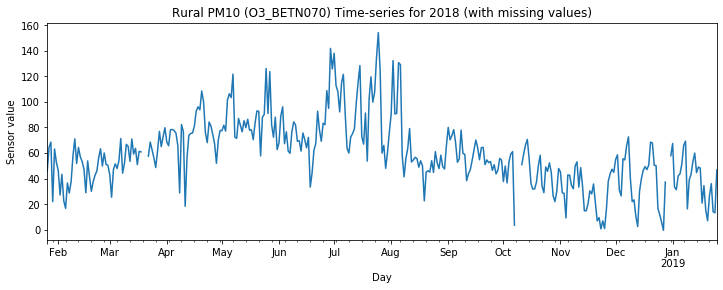

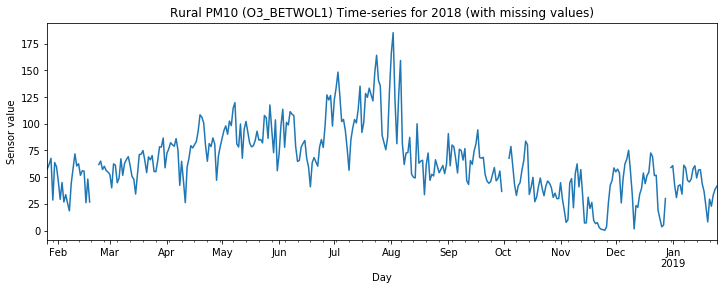

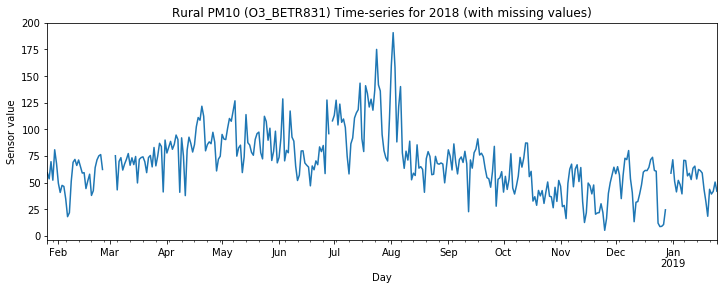

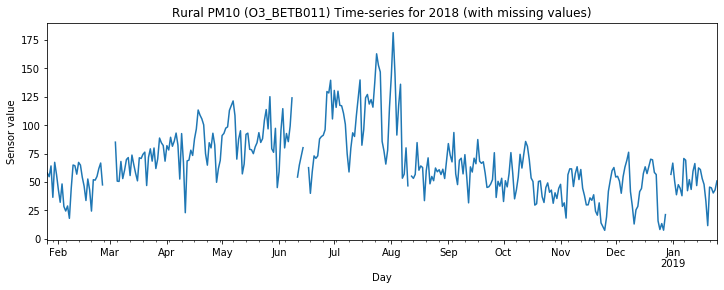

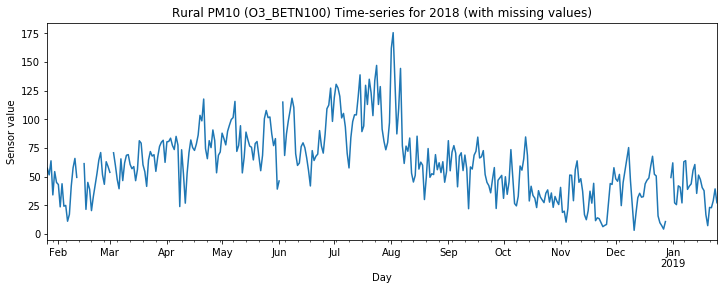

In [22]:
# Test plot stations
stationsToCheck = ['O3_BETN070', 'O3_BETWOL1', 'O3_BETR831', 'O3_BETB011','O3_BETN100']
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2018 (with missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

### On missing values get the reading from the closest station

Get the correlation between different stations (columns):

In [23]:
import math
from collections import OrderedDict

def getCorrelation(station1, station2):
    return ts[station1].corr(ts[station2])

correlationStationToStation = {}

for station1 in ts.columns:
    if "O3_" in station1 and "-1" not in station1:
        correlationsToStation = {}
        for station2 in ts.columns:
            if station1 != station2 and "O3_" in station2 and "-1" not in station2: 
                correlation = getCorrelation(station1, station2)  
                if correlation != None and not np.isnan(correlation):
                    correlationsToStation[station2] = correlation
        correlationStationToStation[station1] = OrderedDict(sorted(correlationsToStation.items(), reverse=True, key=lambda t: t[1]))

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [24]:
len(correlationStationToStation)

47

In [25]:
correlationStationToStation["O3_BETR831"].keys()

odict_keys(['O3_BETR701', 'O3_BETR710', 'O3_BETR801', 'O3_BETB004', 'O3_BETR841', 'O3_BETN052', 'O3_BE0312A', 'O3_BETB006', 'O3_BETB011', 'O3_BETWOL1', 'O3_BETN060', 'O3_BETN043', 'O3_BETN035', 'O3_BETAND3', 'O3_BETR001', 'O3_BETN045', 'O3_BETR222', 'O3_BETR502', 'O3_BETN070', 'O3_BETN050', 'O3_BETN051', 'O3_BETR221', 'O3_BETN040', 'O3_BETR811', 'O3_BETN012', 'O3_BETM705', 'O3_BETR240', 'O3_BETR012', 'O3_BETR740', 'O3_BETN029', 'O3_BETN054', 'O3_BETN046', 'O3_BETN016', 'O3_BETN041', 'O3_BETR201', 'O3_BETN027', 'O3_BETN073', 'O3_BETN063', 'O3_BETN093', 'O3_BETN113', 'O3_BETN121', 'O3_BETN100', 'O3_BETN132', 'O3_BETN066', 'O3_BETN085', 'O3_BETR501'])

In [26]:
getCorrelation("O3_BETN043", "O3_BETR201")

0.8697180686139225

In [27]:
correlationStationToStation["O3_BETN043"].keys()

odict_keys(['O3_BETAND3', 'O3_BETR841', 'O3_BETB011', 'O3_BETB004', 'O3_BETB006', 'O3_BETR710', 'O3_BETN070', 'O3_BETR701', 'O3_BETR001', 'O3_BETR801', 'O3_BETR012', 'O3_BETN035', 'O3_BETN050', 'O3_BETN040', 'O3_BETN045', 'O3_BETR811', 'O3_BETN051', 'O3_BETR740', 'O3_BETR221', 'O3_BETR831', 'O3_BETWOL1', 'O3_BETN054', 'O3_BETN016', 'O3_BETN073', 'O3_BETN046', 'O3_BETN060', 'O3_BETN027', 'O3_BETR502', 'O3_BETN052', 'O3_BETN063', 'O3_BETM705', 'O3_BETR201', 'O3_BETR240', 'O3_BETN012', 'O3_BETR222', 'O3_BETN093', 'O3_BETN041', 'O3_BE0312A', 'O3_BETN113', 'O3_BETN132', 'O3_BETN121', 'O3_BETN100', 'O3_BETN029', 'O3_BETN085', 'O3_BETN066'])

In [28]:
correlationStationToStation["O3_BETN043"]

OrderedDict([('O3_BETAND3', 0.956160316137764),
             ('O3_BETR841', 0.9431241470907821),
             ('O3_BETB011', 0.94071981264409),
             ('O3_BETB004', 0.9341218588936953),
             ('O3_BETB006', 0.9332089091123109),
             ('O3_BETR710', 0.929265915648425),
             ('O3_BETN070', 0.9288142945815943),
             ('O3_BETR701', 0.9215093758175611),
             ('O3_BETR001', 0.9189699460794417),
             ('O3_BETR801', 0.9179765532557406),
             ('O3_BETR012', 0.9161266484662841),
             ('O3_BETN035', 0.9151076730563689),
             ('O3_BETN050', 0.9139667116960462),
             ('O3_BETN040', 0.9133499785731557),
             ('O3_BETN045', 0.9072946741413414),
             ('O3_BETR811', 0.9005336209527298),
             ('O3_BETN051', 0.8978969621210994),
             ('O3_BETR740', 0.896080426485684),
             ('O3_BETR221', 0.8959590497379695),
             ('O3_BETR831', 0.8956777273132138),
             ('O3_BETWOL1

In [29]:
ts2 = ts.copy()
# TODO: Normalized datetime index, removing the hour
ts2.index = ts2.index.normalize()

for dataRow in ts2.itertuples(index=True, name='Pandas'):
    date = dataRow[0]
    for stationLabel in ts2.columns:       
        if "O3_" in stationLabel and "-1" not in stationLabel:       
            try: # TODO: isnnan.any() for cells with dual values
                if np.isnan(ts2.at[date, stationLabel]):  # If no value at station
                    for closestStationLabel in correlationStationToStation[stationLabel].keys():                
                        closestValue = ts.at[date, closestStationLabel]
                        if not np.isnan(closestValue):
                            ts2.at[date, stationLabel] = closestValue
                            break  # Exit the loop    
            except (ValueError,IOError) as err:
                print("date: ", date, "stationLabel: ", stationLabel)
                print(err)
                
ts = ts2  

In [30]:
ts["O3_BETN043"]["2016-09-2"]

40.125

In [31]:
ts.head(365)["O3_BETN043"].head(20)

1990-01-01    28.250
1990-01-02    11.429
1990-01-03    30.333
1990-01-04     4.375
1990-01-05     2.500
1990-01-06    12.875
1990-01-07    17.750
1990-01-08    11.750
1990-01-09    14.000
1990-01-10    25.833
1990-01-11    24.571
1990-01-12    27.125
1990-01-13    14.286
1990-01-14     1.625
1990-01-15    25.625
1990-01-16    43.000
1990-01-17    58.500
1990-01-18    15.125
1990-01-19    31.875
1990-01-20    36.667
Freq: D, Name: O3_BETN043, dtype: float64

In [32]:
ts.tail(365)["O3_BETN043"].head(20)

2018-01-26    32.937500
2018-01-27    50.500000
2018-01-28    54.750000
2018-01-29    17.000000
2018-01-30    49.062500
2018-01-31    48.937500
2018-02-01    33.625000
2018-02-02    15.687500
2018-02-03    44.375000
2018-02-04    27.750000
2018-02-05    21.875000
2018-02-06    28.375000
2018-02-07     9.125000
2018-02-08    32.750000
2018-02-09    49.250000
2018-02-10    61.062500
2018-02-11    42.250000
2018-02-12    53.357143
2018-02-13    52.000000
2018-02-14    47.562500
Freq: D, Name: O3_BETN043, dtype: float64

Check if missing values indeed filled:

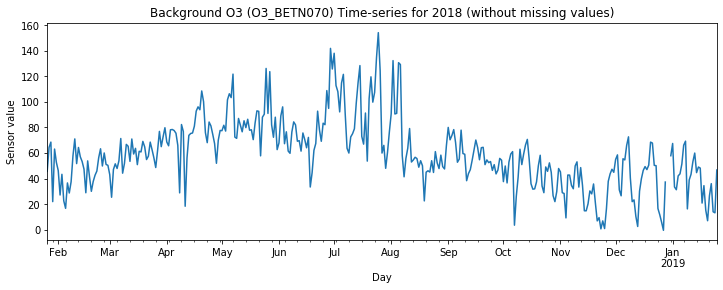

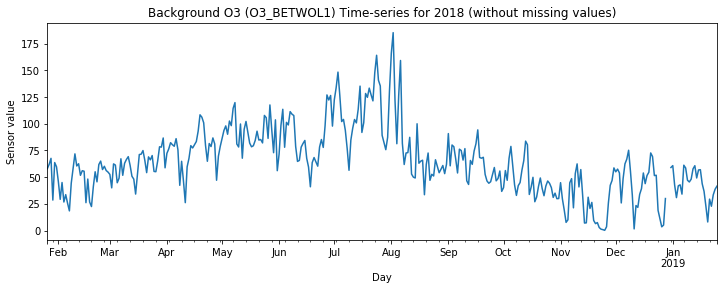

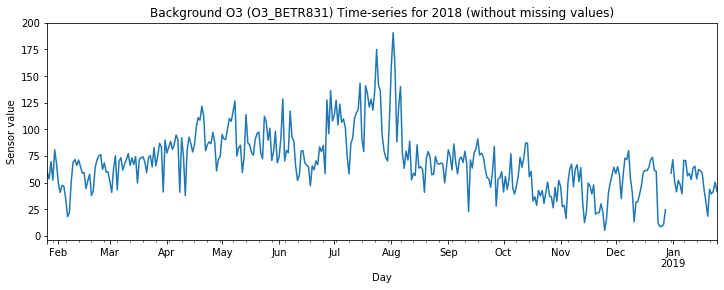

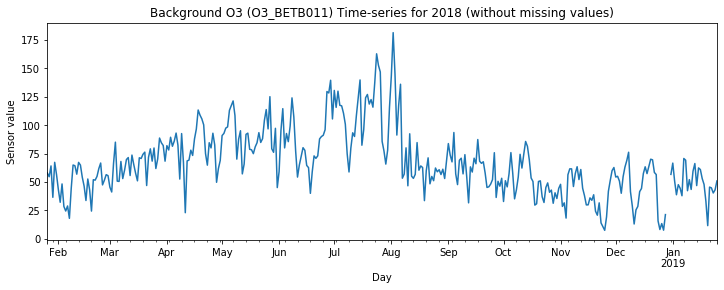

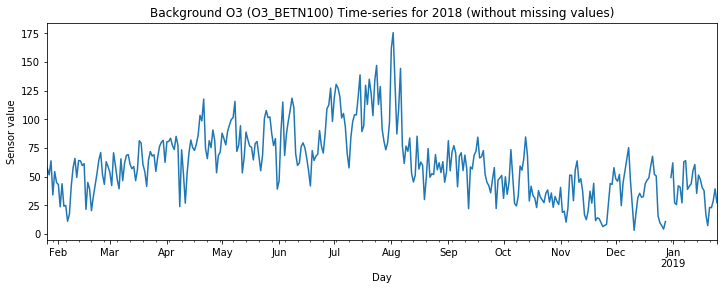

In [33]:
# Test plot stations
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Background O3 ({}) Time-series for 2018 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

Adding weather data into the dataframe:

In [34]:
weatherDataColumns = ['PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4',  # Attach all the ECMWF weather labels
                 'SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH',
                 'TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T',
                 'RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR']
weatherDataNew = genfromtxt('ECMWF\BETN073_51vars_19900101To20181231.csv', delimiter=',')
minWeatherDate = "01-01-1990"
maxWeatherDate = "31-12-2018"
weather_ts = pd.DataFrame(weatherDataNew, index=pd.date_range(start=minWeatherDate, end=maxWeatherDate, freq='D'), columns=weatherDataColumns)

weather_ts.index = weather_ts.index.normalize() # Normalized datetime index, removing the hour

print(weather_ts.shape, weatherDataNew.shape)

(10592, 51) (10592, 51)


In [35]:
weather_ts.head()

,PARCS,CI,RSN,SST,ISTL1,ISTL2,ISTL3,ISTL4,SWVL1,SWVL2,...,MX2T,MN2T,RO,TCO3,TP,IEWS,SKT,STL4,FAL,FSR
1990-01-01,444553.3125,0.0,99.999985,273.352539,271.459824,271.459839,271.459854,271.459961,0.298347,0.299438,...,275.128418,274.782593,0.000045,0.005519,0.0,-0.020990,274.543457,282.382812,0.189940,0.191961
1990-01-02,450023.5625,0.0,99.999985,273.351562,271.460388,271.460434,271.459976,271.459961,0.297440,0.298363,...,277.109863,276.395264,0.000046,0.005992,0.0,-0.002058,276.202881,282.292175,0.189814,0.191961
1990-01-03,453719.4375,0.0,99.999985,273.350586,271.460007,271.460312,271.460175,271.459961,0.296425,0.297562,...,275.929443,275.655884,0.000047,0.007510,0.0,-0.184821,275.471191,282.198242,0.189696,0.191964
1990-01-04,457172.3750,0.0,99.999985,273.350830,271.459717,271.459656,271.460220,271.459961,0.295204,0.296326,...,275.460815,274.836182,0.000048,0.006678,0.0,0.105883,274.214111,282.104309,0.189574,0.146393
1990-01-05,461869.8750,0.0,99.999985,273.351562,271.459808,271.460114,271.460175,271.459961,0.295425,0.296227,...,278.035156,277.420288,0.000048,0.006242,0.0,0.028112,276.170654,282.006409,0.189452,0.191962


In [36]:
weather_ts.tail()

,PARCS,CI,RSN,SST,ISTL1,ISTL2,ISTL3,ISTL4,SWVL1,SWVL2,...,MX2T,MN2T,RO,TCO3,TP,IEWS,SKT,STL4,FAL,FSR
2018-12-27,414830.6250,0.0,99.999985,275.198730,271.459656,271.460007,271.460220,271.459961,0.233154,0.234200,...,277.234741,276.372559,0.000014,0.006669,0.000001,0.009318,276.572266,283.189819,0.161208,0.113639
2018-12-28,414884.9375,0.0,99.999985,275.067871,271.460251,271.459564,271.460114,271.459961,0.231964,0.232590,...,278.856689,278.332764,0.000015,0.006754,0.000083,0.045983,277.466797,282.989136,0.161116,0.127085
2018-12-29,419315.0625,0.0,99.999985,275.070312,271.459839,271.460159,271.460175,271.459961,0.232742,0.232025,...,281.661865,280.991211,0.000015,0.006992,0.000301,0.534758,280.926758,282.913940,0.161013,0.181972
2018-12-30,420687.8750,0.0,99.999985,275.152588,271.459610,271.460220,271.459824,271.459961,0.231911,0.231865,...,280.683838,279.797607,0.000016,0.006464,0.000254,0.152843,280.461426,282.917175,0.160918,0.181867
2018-12-31,431265.4375,0.0,99.999985,275.113525,271.459930,271.460220,271.459991,271.459961,0.232346,0.232468,...,282.099854,281.288086,0.000016,0.005841,0.000043,0.077620,280.570679,282.806213,0.160815,0.181866


In [37]:
weather_ts.index[0]

Timestamp('1990-01-01 00:00:00', freq='D')

In [38]:
ts.index[0]

Timestamp('1990-01-01 00:00:00', freq='D')

In [39]:
# Attach weather data
ts3 = ts.copy()

for dataRow in weather_ts.itertuples(index=True, name='weather_ts'):  # days from 1-1-1990 -> 1-1-1995
    date = dataRow[0]
    if date >= ts3.index[0]:  # After 1995, else throws exception
        for weatherVariableLabel in weather_ts.columns:    
            try:
                valuets3 = ts3.at[date, weatherVariableLabel]
                if np.isnan(valuets3):
                    weatherValue = weather_ts.at[date, weatherVariableLabel]
                    if not np.isnan(weatherValue):
                        ts3.at[date, weatherVariableLabel] = weatherValue
            except (ValueError,IOError) as err:
                print("EXCEPTION: date: ", date, "weatherVariableLabel: ", weatherVariableLabel)
                print(err)

ts = ts3

In [40]:
# Remove 2019 from TS
ts = ts["1990-01-01":"2018-12-31"]

In [41]:
ts.tail(365)["O3_BETN043"].head(20)

2018-01-01    60.875000
2018-01-02    70.357143
2018-01-03    68.937500
2018-01-04    65.875000
2018-01-05    23.562500
2018-01-06    32.687500
2018-01-07    21.062500
2018-01-08    17.250000
2018-01-09    28.750000
2018-01-10    16.142857
2018-01-11     3.937500
2018-01-12    33.125000
2018-01-13    14.937500
2018-01-14    47.937500
2018-01-15    56.750000
2018-01-16    62.214286
2018-01-17    62.937500
2018-01-18    44.500000
2018-01-19    55.625000
2018-01-20    53.437500
Freq: D, Name: O3_BETN043, dtype: float64

In [42]:
ts["SST"].tail(10)

2018-12-22    275.188232
2018-12-23    275.229736
2018-12-24    275.209717
2018-12-25    275.186279
2018-12-26    275.211670
2018-12-27    275.198730
2018-12-28    275.067871
2018-12-29    275.070312
2018-12-30    275.152588
2018-12-31    275.113525
Freq: D, Name: SST, dtype: float64

In [43]:
ts.head()

,O3_BE0312A,O3_BETAND3,O3_BETB004,O3_BETB006,O3_BETB011,O3_BETM705,O3_BETN012,O3_BETN016,O3_BETN027,O3_BETN029,...,O3_BETR501-1,O3_BETR502-1,O3_BETR701-1,O3_BETR710-1,O3_BETR740-1,O3_BETR801-1,O3_BETR811-1,O3_BETR831-1,O3_BETR841-1,O3_BETWOL1-1
1990-01-01,10.167,28.250,37.000,28.250,28.250,37.000,10.167,28.250,28.250,10.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,21.875,11.429,21.875,11.429,11.429,21.875,21.875,11.429,11.875,21.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,30.333,30.333,30.333,30.333,30.333,30.333,30.333,19.667,19.667,30.333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,9.167,4.375,9.167,4.375,4.375,9.167,9.167,4.375,12.714,9.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,9.750,2.500,9.750,2.500,2.500,9.750,9.750,2.500,14.500,9.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
ts.tail()

,O3_BE0312A,O3_BETAND3,O3_BETB004,O3_BETB006,O3_BETB011,O3_BETM705,O3_BETN012,O3_BETN016,O3_BETN027,O3_BETN029,...,O3_BETR501-1,O3_BETR502-1,O3_BETR701-1,O3_BETR710-1,O3_BETR740-1,O3_BETR801-1,O3_BETR811-1,O3_BETR831-1,O3_BETR841-1,O3_BETWOL1-1
2018-12-27,5.000,7.500000,1.250000,0.500000,7.500000,1.250000,5.000,2.375000,0.625000,18.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28,18.250,21.214286,8.071429,8.428571,21.214286,6.642857,18.250,10.833333,11.142857,45.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,59.125,56.625000,59.437500,57.562500,56.625000,59.562500,59.125,47.812500,53.375000,65.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add 1-day lags:

In [45]:
# TODO: add -1 lag
previous_columns = ts.columns
for column in previous_columns:
    if "O3_" in column and "-1" not in column:
        ts[column + "-1"] = ts[column].shift()

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Add 7-day lags:

In [ ]:
# TODO: Add up to -7 day lags
max_lag = 7

previous_columns = ts.columns
for column in previous_columns:
    
    if "O3_" in column and ("-" + str(max_lag)) not in column and "-" not in column:
        
        ts_column_shifted = ts[column].shift()
        
        for lag in range(2, max_lag + 1):            
            ts_column_shifted = ts_column_shifted.shift()            
            ts[column + ("-" + str(lag))] = ts_column_shifted


In [ ]:
ts.head(6000).tail(9)["O3_BETN043"]

In [ ]:
ts.head(6000).tail(9)["O3_BETN043-1"]

In [ ]:
ts.head(6000).tail(9)["O3_BETN043-5"]

In [ ]:
ts.head(6000).tail(9)["O3_BETN043-7"]

In [46]:
ts.head(6000).tail(5)["PARCS"]

2006-06-01    2990379.0
2006-06-02    2987812.0
2006-06-03    2989369.0
2006-06-04    2993987.0
2006-06-05    3002104.0
Freq: D, Name: PARCS, dtype: float64

In [47]:
ts.head(6000).tail(5)["FSR"]

2006-06-01    0.146394
2006-06-02    0.146390
2006-06-03    0.146392
2006-06-04    0.146391
2006-06-05    0.146393
Freq: D, Name: FSR, dtype: float64

Time-series plot of O3, first 365 days (1990, with missing data):

KeyError: 'O3_BETN070-7'

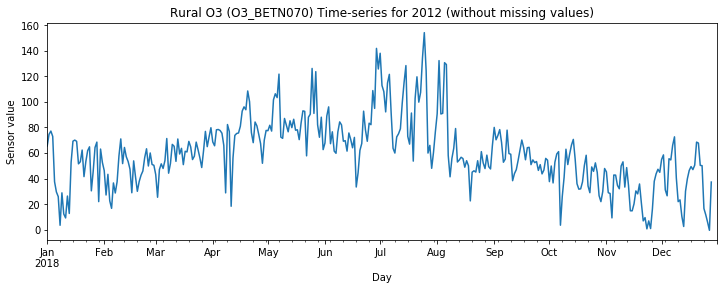

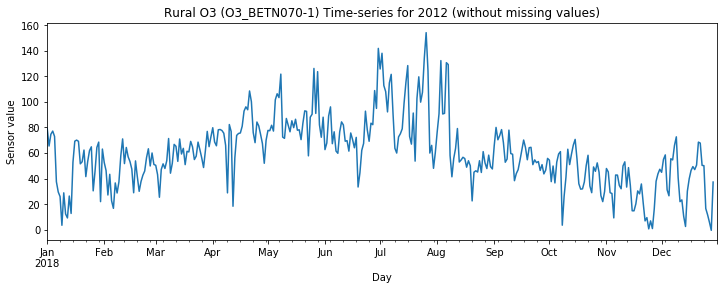

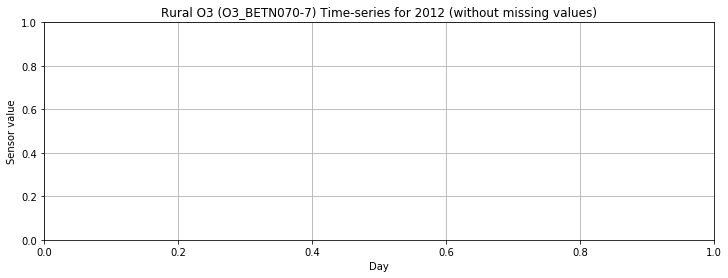

In [49]:
# Test plot stations and lags
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural O3 ({}) Time-series for 2012 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);
    
    stationToCheckLag = stationToCheck + "-1"
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural O3 ({}) Time-series for 2012 (without missing values)'.format(stationToCheckLag))
    ax.grid(True)
    ts.tail(365)[stationToCheckLag].plot(ax = ax);
    
    stationToCheckLag = stationToCheck + "-7"
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural O3 ({}) Time-series for 2012 (without missing values)'.format(stationToCheckLag))
    ax.grid(True)
    ts.tail(365)[stationToCheckLag].plot(ax = ax);

Plot other time-series variables (Temperature 2m):

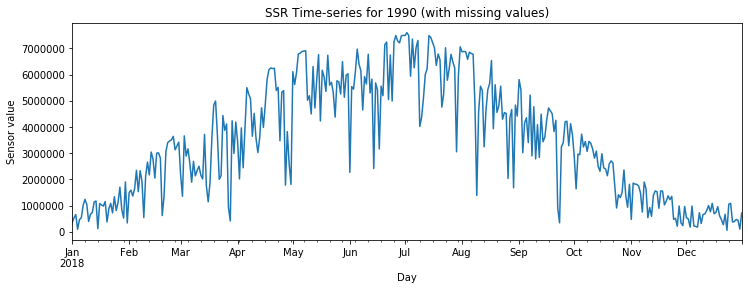

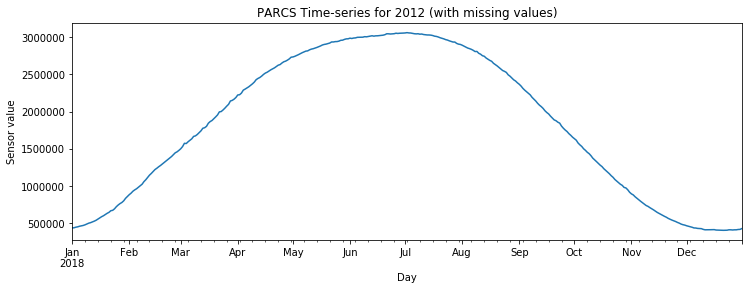

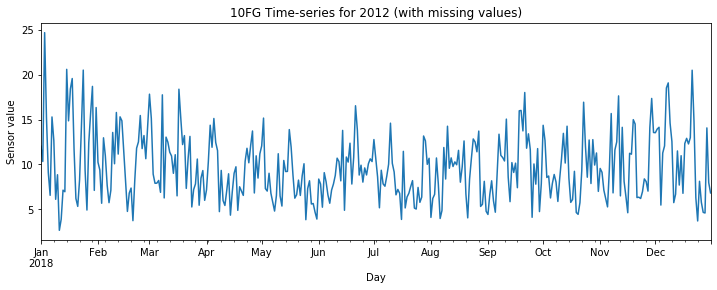

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('SSR Time-series for 1990 (with missing values)')
ax.grid(True)
# ts.tail(365)['2T'].plot(ax = ax);
# ['O3', '10FG', 'BLH', '10U', '2T', 'SSR', 'SUND', 'O3-1']
#['O3','PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4','SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH','TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T','RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR','O3-1']
ts.tail(365)['SSR'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('PARCS Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['PARCS'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('10FG Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['10FG'].plot(ax = ax);

Lag variable (-1 day):

In [52]:
ts.tail(10)[stationLabels[0]]  

2018-12-22    49.937500
2018-12-23    48.375000
2018-12-24    23.428571
2018-12-25    17.062500
2018-12-26    14.937500
2018-12-27     5.000000
2018-12-28    18.250000
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    59.125000
Freq: D, Name: O3_BE0312A, dtype: float64

In [53]:
ts.tail(10)[stationLabels[0] + '-1']

2018-12-22    70.562500
2018-12-23    49.937500
2018-12-24    48.375000
2018-12-25    23.428571
2018-12-26    17.062500
2018-12-27    14.937500
2018-12-28     5.000000
2018-12-29    18.250000
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: O3_BE0312A-1, dtype: float64

In [54]:
ts.tail(10)[stationLabels[1]]

2018-12-22    58.312500
2018-12-23    56.500000
2018-12-24    15.625000
2018-12-25     8.071429
2018-12-26    13.312500
2018-12-27     7.500000
2018-12-28    21.214286
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    56.625000
Freq: D, Name: O3_BETAND3, dtype: float64

In [55]:
ts.tail(10)[stationLabels[1] + '-1']

2018-12-22    69.437500
2018-12-23    58.312500
2018-12-24    56.500000
2018-12-25    15.625000
2018-12-26     8.071429
2018-12-27    13.312500
2018-12-28     7.500000
2018-12-29    21.214286
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: O3_BETAND3-1, dtype: float64

In [56]:
ts.tail(10)[stationLabels[2]]

2018-12-22    54.937500
2018-12-23    52.062500
2018-12-24    14.285714
2018-12-25    13.375000
2018-12-26     7.285714
2018-12-27     1.250000
2018-12-28     8.071429
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    59.437500
Freq: D, Name: O3_BETB004, dtype: float64

In [57]:
ts.tail(10)[stationLabels[2] + '-1']

2018-12-22    70.312500
2018-12-23    54.937500
2018-12-24    52.062500
2018-12-25    14.285714
2018-12-26    13.375000
2018-12-27     7.285714
2018-12-28     1.250000
2018-12-29     8.071429
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: O3_BETB004-1, dtype: float64

In [58]:
ts.tail(10)[stationLabels[3]]

2018-12-22    43.062500
2018-12-23    40.812500
2018-12-24    12.750000
2018-12-25    10.500000
2018-12-26     4.857143
2018-12-27     0.500000
2018-12-28     8.428571
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    57.562500
Freq: D, Name: O3_BETB006, dtype: float64

In [59]:
ts.tail(10)[stationLabels[3] + '-1']

2018-12-22    67.125000
2018-12-23    43.062500
2018-12-24    40.812500
2018-12-25    12.750000
2018-12-26    10.500000
2018-12-27     4.857143
2018-12-28     0.500000
2018-12-29     8.428571
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: O3_BETB006-1, dtype: float64

In [60]:
ts.isna().sum().sum()

811

In [61]:
ts.shape

(10592, 145)

Not useful interpolations: Cubic and Spline (order 2-5+) seem to have very high leverage, skewing the original data:

Useful interpolations: 'from_derivatives' (piecewise polynomial interpolation) and linear. (Probably) the most interesting interpolation: PCHIP 1-d monotonic cubic interpolation (see:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator). Compared to the plain cubic interpolation, doesn't seem to skew the original data points. Pchip looks similar to the linear interpolation, with some extra smoothing.

In [62]:
ts_interpolated = ts.interpolate(method='linear',limit=8,limit_direction='both')  # 8 days
ts_interpolated.head(10)['O3_BETN066']

1990-01-01    28.250
1990-01-02    11.429
1990-01-03    30.333
1990-01-04    12.714
1990-01-05    14.500
1990-01-06    23.143
1990-01-07    17.750
1990-01-08    20.625
1990-01-09    36.750
1990-01-10    54.571
Freq: D, Name: O3_BETN066, dtype: float64

In [63]:
print("Count of NaN values: ", np.isnan(ts_interpolated).any().sum())

Count of NaN values:  0


In [64]:
print("Count of zero values: ", ts_interpolated.size - np.count_nonzero(ts_interpolated))

Count of zero values:  68539


In [65]:
len(ts.columns)

145

In [66]:
ts_interpolated.isnull().sum().sum()

0

In [67]:
ts_interpolated.isna().sum().sum()

0

In [68]:
# Store to time-series csv
# file_name = "ALL_BE_51vars_O3_O3-1_19900101To20181231.csv"
file_name = "ALL_BE_51vars_O3_O3-7_19900101To20181231.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')

#### Calendar data

Conversion of calendar data into cyclical features within [-1, 1].
Inspiration: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [69]:
ts_interpolated.head()

,O3_BE0312A,O3_BETAND3,O3_BETB004,O3_BETB006,O3_BETB011,O3_BETM705,O3_BETN012,O3_BETN016,O3_BETN027,O3_BETN029,...,O3_BETR502-1,O3_BETR701-1,O3_BETR710-1,O3_BETR740-1,O3_BETR801-1,O3_BETR811-1,O3_BETR831-1,O3_BETR841-1,O3_BETWOL1-1,O3_BETR221-1
1990-01-01,10.167,28.250,37.000,28.250,28.250,37.000,10.167,28.250,28.250,10.167,...,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,10.167
1990-01-02,21.875,11.429,21.875,11.429,11.429,21.875,21.875,11.429,11.875,21.875,...,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,10.167
1990-01-03,30.333,30.333,30.333,30.333,30.333,30.333,30.333,19.667,19.667,30.333,...,21.875,21.875,21.875,11.875,21.875,21.875,21.875,21.875,21.875,11.875
1990-01-04,9.167,4.375,9.167,4.375,4.375,9.167,9.167,4.375,12.714,9.167,...,30.333,30.333,30.333,19.667,30.333,30.333,30.333,30.333,30.333,19.667
1990-01-05,9.750,2.500,9.750,2.500,2.500,9.750,9.750,2.500,14.500,9.750,...,9.167,9.167,9.167,9.167,9.167,9.167,9.167,9.167,9.167,12.714


In [70]:
ts_interpolated.index.dayofweek

Int64Index([0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            ...
            5, 6, 0, 1, 2, 3, 4, 5, 6, 0],
           dtype='int64', length=10592)

In [71]:
ts_interpolated.index.dayofyear

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            356, 357, 358, 359, 360, 361, 362, 363, 364, 365],
           dtype='int64', length=10592)

In [72]:
ts_interpolated.index.weekofyear.max()

53

In [73]:
def getCyclicalFeature(column):
    return np.sin((column - column.min())*(2. * (np.pi / column.max()))), np.cos((column - column.min())*(2. * (np.pi / column.max())))

In [74]:
sinCyclicalMonth, cosCyclicalMonth = getCyclicalFeature(ts_interpolated.index.month)
sinCyclicalDayOfWeek, cosCyclicalDayOfWeek = getCyclicalFeature(ts_interpolated.index.dayofweek)
sinCyclicalDayOfYear, cosCyclicalDayOfYear = getCyclicalFeature(ts_interpolated.index.dayofyear)
sinCyclicalWeekOfYear, cosCyclicalWeekOfYear = getCyclicalFeature(ts_interpolated.index.weekofyear)

In [75]:
ts_interpolated['sin_cyclical_month'] = sinCyclicalMonth
ts_interpolated['cos_cyclical_month'] = cosCyclicalMonth
ts_interpolated['sin_cyclical_day_of_week'] = sinCyclicalDayOfWeek
ts_interpolated['cos_cyclical_day_of_week'] = cosCyclicalDayOfWeek
ts_interpolated['sin_cyclical_day_of_year'] = sinCyclicalDayOfYear
ts_interpolated['cos_cyclical_day_of_year'] = cosCyclicalDayOfYear
ts_interpolated['sin_cyclical_week_of_year'] = sinCyclicalWeekOfYear
ts_interpolated['cos_cyclical_week_of_year'] = cosCyclicalWeekOfYear

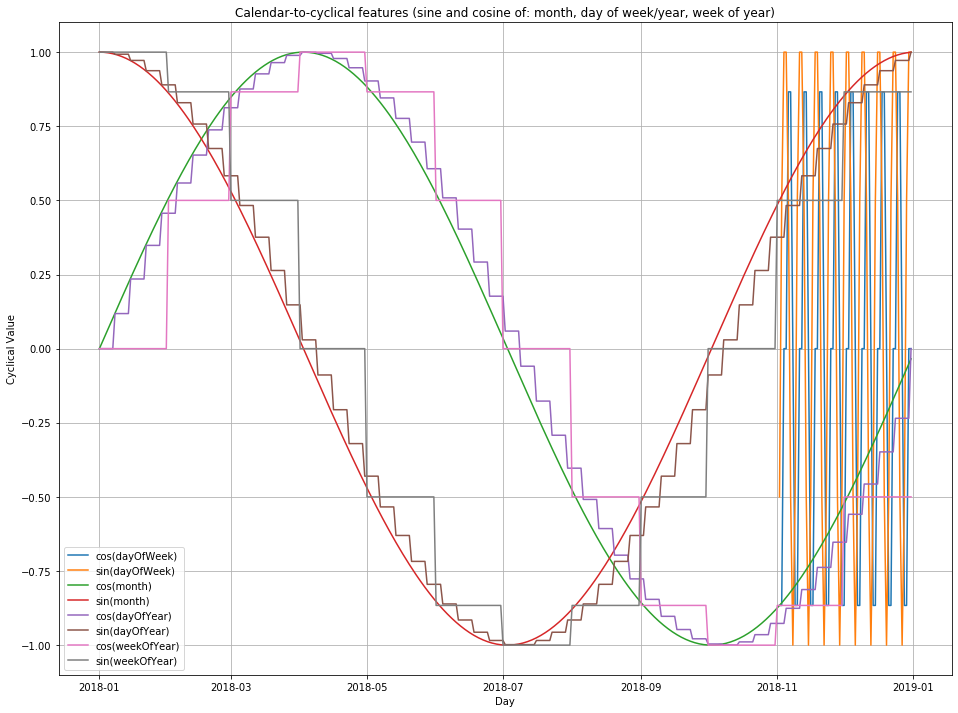

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_ylabel('Cyclical Value')
ax.set_xlabel('Day')
ax.set_title('Calendar-to-cyclical features (sine and cosine of: month, day of week/year, week of year)')
ax.grid(True)

ax.plot(ts_interpolated['sin_cyclical_day_of_week'].tail(60))
ax.plot(ts_interpolated['cos_cyclical_day_of_week'].tail(60))
ax.plot(ts_interpolated['sin_cyclical_day_of_year'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_day_of_year'].tail(365))
ax.plot(ts_interpolated['sin_cyclical_week_of_year'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_week_of_year'].tail(365))
ax.plot(ts_interpolated['sin_cyclical_month'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_month'].tail(365))

ax.legend(['cos(dayOfWeek)', 'sin(dayOfWeek)', 'cos(month)', 'sin(month)', 'cos(dayOfYear)', 'sin(dayOfYear)', 'cos(weekOfYear)', 'sin(weekOfYear)'])

In [77]:
# Store to time-series csv
# file_name = "ALL_BE_51vars_calendar_O3_O3-1_19900101To20181231.csv"
file_name = "ALL_BE_51vars_calendar_O3_O3-7_19900101To20181231.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')